In [412]:
import pandas as pd

In [414]:
import pandas as pd
img_train = pd.read_csv('img_train.csv')
demo_viome_train = pd.read_csv('demo_viome_train.csv')
cgm_train = pd.read_csv('cgm_train.csv')
img_train = img_train.sort_values(by=['Subject ID', 'Day'],ascending=True)
demo_viome_train = demo_viome_train.sort_values(by=['Subject ID'],ascending=True)
cgm_train = cgm_train.sort_values(by=['Subject ID', 'Day'],ascending=True)


In [416]:
demo_viome_train=pd.merge(img_train, demo_viome_train, on="Subject ID", how="left")
demo_viome_train=demo_viome_train.drop(columns=['Image Before Breakfast', 'Image Before Lunch'])
demo_viome_train.head()

,Subject ID,Day,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,...,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,1,2,27,0,133.8,65.0,Hispanic/Latino,1,5.4,91.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
1,1,3,27,0,133.8,65.0,Hispanic/Latino,1,5.4,91.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
2,1,4,27,0,133.8,65.0,Hispanic/Latino,1,5.4,91.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
3,1,5,27,0,133.8,65.0,Hispanic/Latino,1,5.4,91.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
4,1,6,27,0,133.8,65.0,Hispanic/Latino,1,5.4,91.0,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."


In [418]:
import numpy as np
import ast
import cv2

default_lunch_image_str = img_train['Image Before Lunch'][0] 

try:
    
    default_lunch_image = ast.literal_eval(default_lunch_image_str)
    default_lunch_image = np.array(default_lunch_image)
    if isinstance(default_lunch_image, np.ndarray):
        print("Image is a valid NumPy array.")
        
        if default_lunch_image.ndim == 3:  # Should be (height, width, 3) for RGB
            print(f"Image shape: {default_lunch_image.shape}")  # Should be (height, width, 3)

            Resize the image
            default_lunch_image = default_lunch_image.astype(np.uint8)
            default_lunch_image_resized = cv2.resize(default_lunch_image, (224, 224))
            print("Image resized successfully.")
        else:
            print("Error: Image does not have 3 dimensions (height, width, channels).")
    else:
        print("Error: The image is not a valid NumPy array.")

except Exception as e:
    print(f"Error parsing image data: {e}")


Image is a valid NumPy array.
Image shape: (64, 64, 3)
Image resized successfully.


In [420]:
import numpy as np
import ast
from tensorflow.keras.preprocessing import image
import cv2

# Resize images to a consistent shape (e.g., 224x224 for CNN models)
def preprocess_images(image_list):
    processed_images = []

    for img_str in image_list:
        try:
            # Convert the string to a nested list, then to a NumPy array
            img = ast.literal_eval(img_str)
            img = np.array(img)

            # Check if the image has the correct shape (64, 64, 3)
            if img.shape == (64, 64, 3):
                # Resize the valid image to 224x224
                img = img.astype(np.uint8)
                img_resized = cv2.resize(img, (224, 224))
            else:
                # If invalid, use the default resized image
                img_resized = default_lunch_image_resized
        except Exception as e:
            # If there's an error in parsing, use the default resized image
            print(f"Error processing image: {e}")
            img_resized = default_lunch_image_resized

        # Append the processed (or default) image to the list
        processed_images.append(img_resized)

    return np.array(processed_images)

lunch_images = preprocess_images(img_train['Image Before Lunch'].tolist())

# Check the shape of the processed images (optional)
print(f"Processed images shape: {lunch_images.shape}")


Processed images shape: (324, 224, 224, 3)


In [421]:
import ast

# Function to process CGM data into usable format
def process_cgm_data(cgm_str):
    cgm_list = ast.literal_eval(cgm_str)  # Converts the string to a list of tuples
    # Extract glucose values (ignore timestamps for now)
    glucose_values = [entry[1] for entry in cgm_list]
    return glucose_values

# Apply to the CGM data column
cgm_train['Processed CGM'] = cgm_train['CGM Data'].apply(process_cgm_data)
cgm_train['Processed CGM'] = cgm_train['Processed CGM'].apply(np.array)
print(cgm_train['Processed CGM'][0].dtype)


float64


In [424]:
from sklearn.preprocessing import StandardScaler

# Normalize numeric features for the model
scaler = StandardScaler()
biometric_features = demo_viome_train.drop(['Subject ID','Day', 'Viome', 'Race'], axis=1)  # Drop Subject ID
biometric_features_normalized = scaler.fit_transform(biometric_features)


In [426]:
label_train = pd.read_csv('label_train.csv')
label_train = label_train.sort_values(by=['Subject ID', 'Day'],ascending=True)

In [428]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Image Model (CNN)
class ImageModel(nn.Module):
    def __init__(self, output_size=512):
        super(ImageModel, self).__init__()
        # Pre-trained ResNet model
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, output_size)  # Adjusting the final layer
        
    def forward(self, x):
        return self.resnet(x)  # Forward pass through ResNet

# CGM Model (LSTM)
class CGMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(CGMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 64)  # Output size 64
        
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        return self.fc(hn[-1])  # Using the hidden state from the last timestep

# Biometric Model (Fully Connected)
class BiometricModel(nn.Module):
    def __init__(self, input_size):
        super(BiometricModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 64)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.relu(self.fc3(x))

# Model (Combining outputs from all three branches)
class MultimodalCaloriePredictor(nn.Module):
    def __init__(self, cgm_input_size, image_output_size, biometric_input_size):
        super(MultimodalCaloriePredictor, self).__init__()
        
        # Models
        self.image_model = ImageModel(output_size=image_output_size)
        self.cgm_model = CGMModel(input_size=cgm_input_size)
        self.biometric_model = BiometricModel(input_size=biometric_input_size)
        
        # Fusion Layer
        self.fc1 = nn.Linear(image_output_size + 64 + 64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output: Predicted lunch calories
    
    def forward(self, image_data, cgm_data, biometric_data):
        # Process each modality
        image_features = self.image_model(image_data)
        cgm_features = self.cgm_model(cgm_data)
        biometric_features = self.biometric_model(biometric_data)
        
        # Concatenate features
        combined_features = torch.cat((image_features, cgm_features, biometric_features), dim=1)
        
        # Pass through fusion layers
        x = torch.relu(self.fc1(combined_features))
        x = torch.relu(self.fc2(x))
        calorie_pred = self.fc3(x)
        
        return calorie_pred


In [430]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class MultimodalDataset(Dataset):
    def __init__(self, image_data, cgm_data, biometric_data, labels):
        self.image_data = image_data
        self.cgm_data = cgm_data
        self.biometric_data = biometric_data
        self.labels = labels
        assert len(self.image_data) == len(self.cgm_data) == len(self.biometric_data) == len(self.labels), \
            "All data arrays must have the same length."
        self.max_cgm_len = max(len(cgm) for cgm in self.cgm_data)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.image_data[idx], dtype=torch.float32)
        cgm = torch.tensor(self.cgm_data[idx], dtype=torch.float32)
        biometric = torch.tensor(self.biometric_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        # Pad the CGM data to the max length
        if len(cgm) < self.max_cgm_len:
            cgm = F.pad(cgm, (0, self.max_cgm_len - len(cgm)), value=0)
        
        
        return image, cgm, biometric, label
        


from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(range(len(lunch_images)), test_size=0.2, random_state=42)

# Create subsets of the data for training and validation
train_images = [lunch_images[i] for i in train_idx]
val_images = [lunch_images[i] for i in val_idx]

train_cgm = [cgm_train['Processed CGM'].iloc[i] for i in train_idx]
val_cgm = [cgm_train['Processed CGM'].iloc[i] for i in val_idx]

train_biometrics = [biometric_features_normalized[i] for i in train_idx]
val_biometrics = [biometric_features_normalized[i] for i in val_idx]

train_labels = label_train['Lunch Calories'].values[train_idx]
val_labels = label_train['Lunch Calories'].values[val_idx]

# Now we can create DataLoader instances for both training and validation datasets
train_dataset = MultimodalDataset(train_images, train_cgm, train_biometrics, train_labels)
val_dataset = MultimodalDataset(val_images, val_cgm, val_biometrics, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)


In [432]:
class RMSRELoss(nn.Module):
    def __init__(self):
        super(RMSRELoss, self).__init__()

    def forward(self, y_true, y_pred):
        # Ensure there is no division by zero
        epsilon = 1e-6
        relative_error = torch.abs(y_true - y_pred) / (y_true + epsilon)  # avoid division by zero
        return torch.sqrt(torch.mean(relative_error ** 2))


In [436]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Function to calculate RMSRE
def rmsre(y_true, y_pred):
    # Ensure no division by zero (add small value to denominator)
    return torch.sqrt(torch.mean(((y_true - y_pred) / (y_true + 1e-6))**2))

# Create the model
model = MultimodalCaloriePredictor(cgm_input_size=1, image_output_size=512, biometric_input_size=biometric_features_normalized.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    train_rmsre = 0
    train_loss = 0
    for images, cgm, biometrics, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Reshape for the CNN
        cgm = cgm.reshape(cgm.size(0), -1, 1)  # Reshape for the LSTM

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, cgm, biometrics)

        # Calculate RMSRE for training
        loss = rmsre(labels.unsqueeze(1), outputs)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        train_rmsre += loss.item()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_rmsre = 0
    with torch.no_grad():  # No need to track gradients during validation
        for images, cgm, biometrics, labels in val_loader:
            images = images.permute(0, 3, 1, 2)
            cgm = cgm.reshape(cgm.size(0), -1, 1)

            # Forward pass
            outputs = model(images, cgm, biometrics)

            # Compute RMSRE for validation
            loss = rmsre(labels.unsqueeze(1), outputs)
            val_loss += loss.item()

            # Calculate RMSRE
            val_rmsre += loss.item()

    # Average the losses and RMSRE
    avg_train_rmsre = train_rmsre / len(train_loader)
    avg_val_rmsre = val_rmsre / len(val_loader)

    # Print the metrics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train RMSRE: {avg_train_rmsre:.4f}")
    print(f"  Validation RMSRE: {avg_val_rmsre:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/7
  Train RMSRE: 0.9828
  Validation RMSRE: 0.8242
Epoch 2/7
  Train RMSRE: 0.7473
  Validation RMSRE: 0.3368
Epoch 3/7
  Train RMSRE: 0.3795
  Validation RMSRE: 0.8054
Epoch 4/7
  Train RMSRE: 0.3433
  Validation RMSRE: 0.3899
Epoch 5/7
  Train RMSRE: 0.3418
  Validation RMSRE: 0.4448
Epoch 6/7
  Train RMSRE: 0.3391
  Validation RMSRE: 0.3772
Epoch 7/7
  Train RMSRE: 0.3254
  Validation RMSRE: 0.3327


In [528]:
img_test = pd.read_csv('img_test.csv')
demo_viome_test = pd.read_csv('demo_viome_test.csv')
cgm_test = pd.read_csv('cgm_test.csv')

In [530]:
demo_viome_test=pd.merge(img_test, demo_viome_test, on="Subject ID", how="left")
demo_viome_test=demo_viome_test.drop(columns=['Image Before Breakfast', 'Image Before Lunch'])
print(demo_viome_test.shape)

(73, 21)


In [532]:
lunch_images_test = preprocess_images(img_test['Image Before Lunch'].tolist())
print(f"Processed images shape: {lunch_images_test.shape}")

Processed images shape: (73, 224, 224, 3)


In [533]:
cgm_test['Processed CGM'] = cgm_test['CGM Data'].apply(process_cgm_data)
cgm_test['Processed CGM'] = cgm_test['Processed CGM'].apply(np.array)

In [536]:
scaler = StandardScaler()
biometric_features_test = demo_viome_test.drop(['Subject ID','Day', 'Viome', 'Race'], axis=1)  # Drop Subject ID
biometric_features_normalized_test = scaler.fit_transform(biometric_features_test)

In [538]:
class MultimodalDataset_test(Dataset):
    def __init__(self, image_data, cgm_data, biometric_data):
        self.image_data = image_data
        self.cgm_data = cgm_data
        self.biometric_data = biometric_data
        assert len(self.image_data) == len(self.cgm_data) == len(self.biometric_data), \
            "All data arrays must have the same length."
        self.max_cgm_len = max(len(cgm) for cgm in self.cgm_data)
        
    def __len__(self):
        return len(self.cgm_data)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.image_data[idx], dtype=torch.float32)
        cgm = torch.tensor(self.cgm_data[idx], dtype=torch.float32)
        biometric = torch.tensor(self.biometric_data[idx], dtype=torch.float32)
        
        # Pad the CGM data to the max length
        if len(cgm) < self.max_cgm_len:
            cgm = F.pad(cgm, (0, self.max_cgm_len - len(cgm)), value=0)
        
        
        return image, cgm, biometric

In [540]:
test_dataset = MultimodalDataset_test(lunch_images_test, cgm_test['Processed CGM'], biometric_features_normalized_test)

In [542]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [544]:
model.eval() 

predictions = []

with torch.no_grad(): 
    for images, cgm, biometrics in test_loader:  
        images = images.permute(0, 3, 1, 2)  
        cgm = cgm.reshape(cgm.size(0), -1, 1)
        outputs = model(images, cgm, biometrics)
        predictions.append(outputs.item())

import pandas as pd

row_ids = list(range(len(predictions)))

results_df = pd.DataFrame({
    'row_id': row_ids,
    'label': predictions
})

results_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'.")


Predictions saved to 'predictions.csv'.


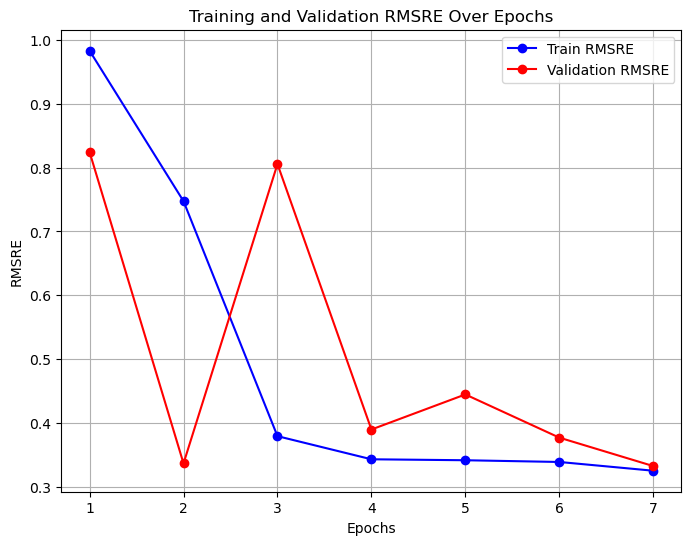

In [546]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3, 4, 5, 6, 7]

# RMSRE values for Training and Validation
train_rmsre = [0.9828, 0.7473, 0.3795, 0.3433, 0.3418, 0.3391, 0.3254]
val_rmsre = [0.8242, 0.3368, 0.8054, 0.3899, 0.4448, 0.3772, 0.3327]

# Plotting the values
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_rmsre, label='Train RMSRE', marker='o', color='blue')
plt.plot(epochs, val_rmsre, label='Validation RMSRE', marker='o', color='red')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('RMSRE')
plt.title('Training and Validation RMSRE Over Epochs')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
